# NBA Data Analysis: Using NBA Advanced Statistics to Predict the Number of Playoff Wins for Each Team!


## Introduction

In recent events, the NBA has taken a noticeable shift towards using data analytics to make informed decisions about roster construction, draft decisions and much more.

Consequently, there has been an explosion of advanced stats being used to better evaluate NBA rosters to increase each respective roster's chances of winning the coveted Larry O'Brien trophy.

This has led me to wanting to answer a specific question; How useful are these advanced stats? 

In this project, I use the [nba_api](https://github.com/swar/nba_api) developed by Swar Patel. It is a free api that allows me to generate my own dataset.

In [6]:
!pip install nba_api

## Libraries

In [546]:
from nba_api.stats.library import parameters
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.endpoints import leaguegamefinder

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

import xgboost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import r2_score, mean_absolute_error

In [618]:
!python3 --version

Python 3.9.19


In [548]:
#Strictly for me. This can be ignored
pd.set_option('display.max_columns',None)

## Building the Dataset

First, we build the dataset of NBA seasons from 2003-2024 by using the nba_api.

In [489]:

# Initialize an empty DataFrame to store all data
all_seasons_df = pd.DataFrame()

# Loop through seasons from 2003-04 to 2023-24
for year in range(2003, 2025):
    season = f"{year}-{str(year+1)[-2:]}"
    params = {'measure_type_detailed_defense': 'Advanced',}
    # Fetch data for the season
    team_stats = leaguedashteamstats.LeagueDashTeamStats(season=season, per_mode_detailed='PerGame',**params)
    season_df = team_stats.get_data_frames()[0]

    # Add a column for the season's year
    season_df['SEASON'] = year+1

    # Combining each season's data frame into one big dataframe. 
    all_seasons_df = pd.concat([all_seasons_df, season_df], ignore_index=True)


This dataset will store "playoff win" values of each team during the playoffs since we are only concerned with the outcomes of each team.

In [491]:

# Initialize an empty DataFrame to store win counts
playoff_wins = pd.DataFrame()

# Loop through each season
for year in range(2003, 2024):
    season = f"{year}-{str(year+1)[-2:]}"

    # Fetch game data
    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable=season, season_type_nullable='Playoffs')
    games_df = gamefinder.get_data_frames()[0]

    # Filter for wins and count them
    wins_df = games_df[games_df['WL'] == 'W'].groupby('TEAM_NAME').size().reset_index(name='PLAYOFF_WINS')
    wins_df['SEASON'] = year+1

    playoff_wins = pd.concat([playoff_wins, wins_df], ignore_index=True)


## Assessing the Dataset

Viewing the dataset and ensuring there is no missing data

In [9]:
all_seasons_df.head(5)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,OFF_RATING_RANK,DEF_RATING_RANK,NET_RATING_RANK,AST_PCT_RANK,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK,SEASON
0,1610612737,Atlanta Hawks,82,28,54,0.341,3981.0,98.2,99.1,103.1,103.9,-4.9,-4.8,0.583,1.22,15.7,0.308,0.686,0.500,0.176,0.465,0.514,93.5,92.68,77.24,7680,0.466,1,25,25,25,4,24,24,26,24,27,24,19,13,17,24,18,17,10,25,2004
1,1610612738,Boston Celtics,82,36,46,0.439,3941.0,99.9,100.7,100.2,102.2,-0.3,-1.5,0.592,1.26,16.1,0.279,0.658,0.473,0.172,0.486,0.532,95.8,94.47,78.73,7757,0.490,1,20,20,20,28,16,17,19,18,23,21,28,26,28,23,5,4,3,19,2004
2,1610612741,Chicago Bulls,82,23,59,0.280,3966.0,93.9,95.6,100.5,102.1,-6.6,-6.5,0.641,1.36,16.7,0.311,0.679,0.491,0.172,0.446,0.486,94.8,93.23,77.69,7694,0.446,1,28,28,28,11,28,16,28,6,19,12,17,18,22,22,29,29,8,27,2004
3,1610612739,Cleveland Cavaliers,82,35,47,0.427,3971.0,98.4,100.6,101.3,103.1,-2.9,-2.6,0.619,1.49,16.9,0.340,0.688,0.514,0.160,0.451,0.498,93.6,91.71,76.43,7577,0.491,1,21,21,21,7,18,20,21,12,10,11,4,12,5,11,28,27,14,18,2004
4,1610612742,Dallas Mavericks,82,52,30,0.634,3961.0,109.6,110.4,104.3,105.9,5.3,4.5,0.591,1.96,17.7,0.335,0.686,0.507,0.128,0.495,0.536,95.7,94.62,78.85,7814,0.527,1,7,7,7,15,1,26,6,19,1,6,6,14,10,1,3,3,2,8,2004


In [11]:
# Checking the shape of the seasons dataset
print('shape:',all_seasons_df.shape)

# Basic info of the seasons dataset
print(all_seasons_df.info())

shape: (629, 47)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TEAM_ID          629 non-null    int64  
 1   TEAM_NAME        629 non-null    object 
 2   GP               629 non-null    int64  
 3   W                629 non-null    int64  
 4   L                629 non-null    int64  
 5   W_PCT            629 non-null    float64
 6   MIN              629 non-null    float64
 7   E_OFF_RATING     629 non-null    float64
 8   OFF_RATING       629 non-null    float64
 9   E_DEF_RATING     629 non-null    float64
 10  DEF_RATING       629 non-null    float64
 11  E_NET_RATING     629 non-null    float64
 12  NET_RATING       629 non-null    float64
 13  AST_PCT          629 non-null    float64
 14  AST_TO           629 non-null    float64
 15  AST_RATIO        629 non-null    float64
 16  OREB_PCT         629 non-null    float64
 17 

In [13]:
# Checking the shape of the playoff wins dataset
print('shape:',playoff_wins.shape)

# Basic info of the playoff wins dataset
print(playoff_wins.info())

shape: (399, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TEAM_NAME     399 non-null    object
 1   PLAYOFF_WINS  399 non-null    int64 
 2   SEASON        399 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ KB
None


In [15]:
#Checking to make sure there are no missing values
print(all_seasons_df.isnull().sum())

TEAM_ID            0
TEAM_NAME          0
GP                 0
W                  0
L                  0
W_PCT              0
MIN                0
E_OFF_RATING       0
OFF_RATING         0
E_DEF_RATING       0
DEF_RATING         0
E_NET_RATING       0
NET_RATING         0
AST_PCT            0
AST_TO             0
AST_RATIO          0
OREB_PCT           0
DREB_PCT           0
REB_PCT            0
TM_TOV_PCT         0
EFG_PCT            0
TS_PCT             0
E_PACE             0
PACE               0
PACE_PER40         0
POSS               0
PIE                0
GP_RANK            0
W_RANK             0
L_RANK             0
W_PCT_RANK         0
MIN_RANK           0
OFF_RATING_RANK    0
DEF_RATING_RANK    0
NET_RATING_RANK    0
AST_PCT_RANK       0
AST_TO_RANK        0
AST_RATIO_RANK     0
OREB_PCT_RANK      0
DREB_PCT_RANK      0
REB_PCT_RANK       0
TM_TOV_PCT_RANK    0
EFG_PCT_RANK       0
TS_PCT_RANK        0
PACE_RANK          0
PIE_RANK           0
SEASON             0
dtype: int64


In [17]:
#Checking to make sure there are no missing values
print(playoff_wins.isnull().sum())

TEAM_NAME       0
PLAYOFF_WINS    0
SEASON          0
dtype: int64


Now, we merge both datasets.

In [20]:
merged_df = pd.merge(all_seasons_df, playoff_wins, how='left', on=['TEAM_NAME', 'SEASON'])
merged_df['PLAYOFF_WINS'] = merged_df['PLAYOFF_WINS'].fillna(0)
merged_df.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TO,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,OFF_RATING_RANK,DEF_RATING_RANK,NET_RATING_RANK,AST_PCT_RANK,AST_TO_RANK,AST_RATIO_RANK,OREB_PCT_RANK,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK,SEASON,PLAYOFF_WINS
0,1610612737,Atlanta Hawks,82,28,54,0.341,3981.0,98.2,99.1,103.1,103.9,-4.9,-4.8,0.583,1.22,15.7,0.308,0.686,0.500,0.176,0.465,0.514,93.5,92.68,77.24,7680,0.466,1,25,25,25,4,24,24,26,24,27,24,19,13,17,24,18,17,10,25,2004,0.0
1,1610612738,Boston Celtics,82,36,46,0.439,3941.0,99.9,100.7,100.2,102.2,-0.3,-1.5,0.592,1.26,16.1,0.279,0.658,0.473,0.172,0.486,0.532,95.8,94.47,78.73,7757,0.490,1,20,20,20,28,16,17,19,18,23,21,28,26,28,23,5,4,3,19,2004,0.0
2,1610612741,Chicago Bulls,82,23,59,0.280,3966.0,93.9,95.6,100.5,102.1,-6.6,-6.5,0.641,1.36,16.7,0.311,0.679,0.491,0.172,0.446,0.486,94.8,93.23,77.69,7694,0.446,1,28,28,28,11,28,16,28,6,19,12,17,18,22,22,29,29,8,27,2004,0.0
3,1610612739,Cleveland Cavaliers,82,35,47,0.427,3971.0,98.4,100.6,101.3,103.1,-2.9,-2.6,0.619,1.49,16.9,0.340,0.688,0.514,0.160,0.451,0.498,93.6,91.71,76.43,7577,0.491,1,21,21,21,7,18,20,21,12,10,11,4,12,5,11,28,27,14,18,2004,0.0
4,1610612742,Dallas Mavericks,82,52,30,0.634,3961.0,109.6,110.4,104.3,105.9,5.3,4.5,0.591,1.96,17.7,0.335,0.686,0.507,0.128,0.495,0.536,95.7,94.62,78.85,7814,0.527,1,7,7,7,15,1,26,6,19,1,6,6,14,10,1,3,3,2,8,2004,1.0


## Visualizations

To make it easier to generate visualizations, I make feature variables to save time.

In [24]:
# These are my independent variables I will be using to determine the number of playoff wins
features = ['W', 'L', 'W_RANK','W_PCT', 'MIN','OFF_RATING', 'DEF_RATING','NET_RATING','NET_RATING_RANK', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT','E_PACE', 'PACE', 'POSS', 'PIE','PIE_RANK']

# This is my independent variable
target = 'PLAYOFF_WINS'

# Both features and target will be used in the correlation matrix
cor_mat_features = ['W', 'L','W_RANK', 'W_PCT', 'MIN','OFF_RATING', 'DEF_RATING','NET_RATING','NET_RATING_RANK', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_PACE', 'PACE','PACE_PER40', 'POSS', 'PIE','PIE_RANK','PLAYOFF_WINS']

team_colors ={
    "Atlanta Hawks": (225, 68, 52),
    "Boston Celtics": (0, 122, 51),
    "Brooklyn Nets": (0, 0, 0),
    "Charlotte Hornets": (0, 120, 140),
    "Charlotte Bobcats": (255, 165, 0), 
    "Chicago Bulls": (206, 17, 65),
    "Cleveland Cavaliers": (134, 0, 56), 
    "Dallas Mavericks": (0, 83, 188), 
    "Denver Nuggets": (13, 34, 64),
    "Detroit Pistons": (200, 16, 46), 
    "Golden State Warriors": (255, 199, 44),
    "Houston Rockets": (44,122,161),
    "Indiana Pacers": (255, 198, 39), 
    "LA Clippers": (200, 16, 46), 
    "Los Angeles Clippers": (200, 16, 46),
    "Los Angeles Lakers": (85, 37, 130),
    "Memphis Grizzlies": (93, 118, 169), 
    "Miami Heat": (152, 0, 46), 
    "Milwaukee Bucks": (0, 71, 27),
    "Minnesota Timberwolves": (35, 97, 146),
    "New Jersey Nets": (0, 42, 96),
    "New Orleans Pelicans": (0, 22, 65), 
    "New Orleans Hornets": (29,17,96),
    "New Orleans/Oklahoma City Hornets": (29,17,96),
    "New York Knicks": (0, 107, 182), 
    "Oklahoma City Thunder": (0, 125, 195),
    "Orlando Magic": (196, 206, 211),
    "Philadelphia 76ers": (0, 107, 182),
    "Phoenix Suns": (229, 95, 32),
    "Portland Trail Blazers": (224, 58, 62),
    "Sacramento Kings": (91, 43, 130),
    "San Antonio Spurs": (196, 206, 211),
    "Seattle SuperSonics": (0, 101, 58), 
    "Toronto Raptors": (206, 17, 65),
    "Utah Jazz": (0, 43, 92),
    "Washington Wizards": (227, 24, 55)
}
palette = {
    team: (r/255, g/255,b/255) for team, (r,g,b) in team_colors.items()
}


# Heat Map


Some key insights from this graph are the variables that highly
correlate with playoff wins. Wins, Losses, Win percentage,
Offensive rating, Defensive Rating, , Net Rating, Effective
Field Goal Percentage, True Shooting percentage and PIE as
well as W_RANK, and PIE_RANK all seem to correlate to a moderate amount so, I will be using these in particular to train my model. 

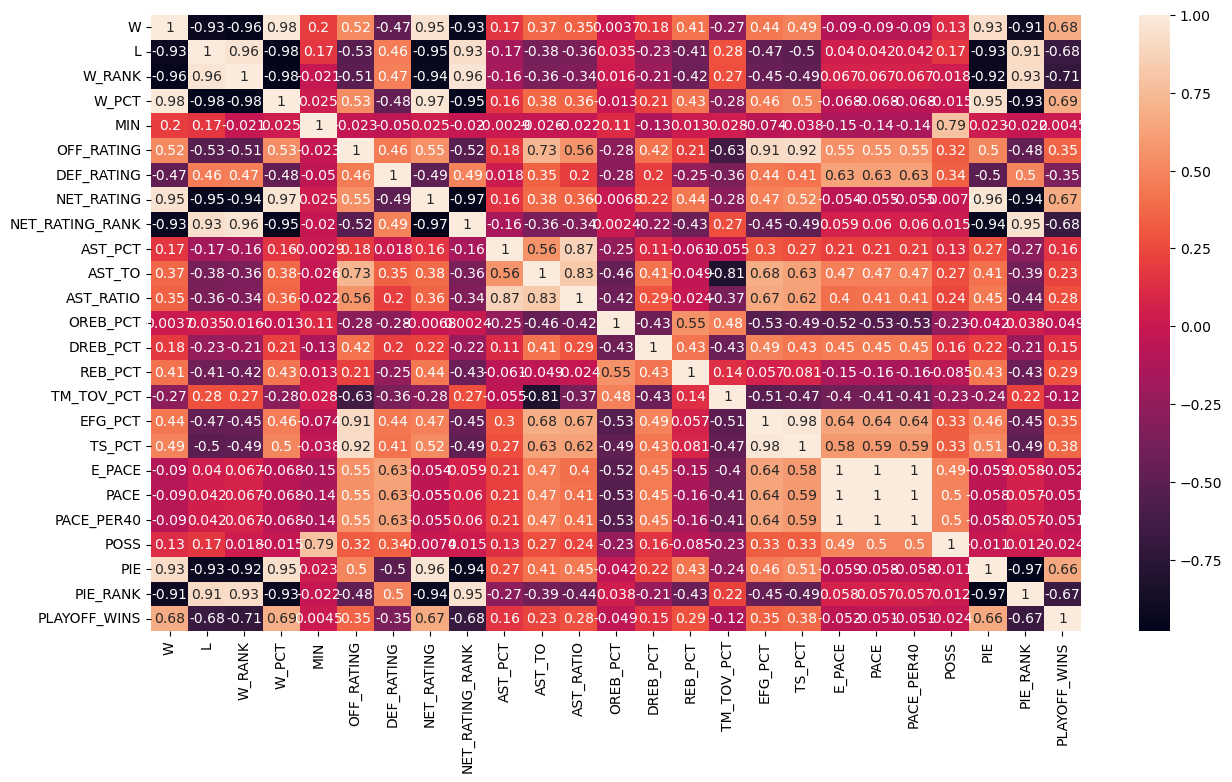

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))  # Size is in inches (width, height)

cor_mat = merged_df[cor_mat_features].corr()
sns.heatmap(cor_mat, annot=True,ax = ax)
plt.show()

## Visualizing the Most Important Features

Based on the correlation matrix: Regular Season Wins, Net Rating, and Player Impact Estimate have the greatest correlation with the number of playoff wins for a team. So, I decided to plot these stats and compare it to how many playoff wins each team had.

As you will see, each stat indeed follows a trend of increasing the number of playoff wins for a team given given an increase of each important stat.

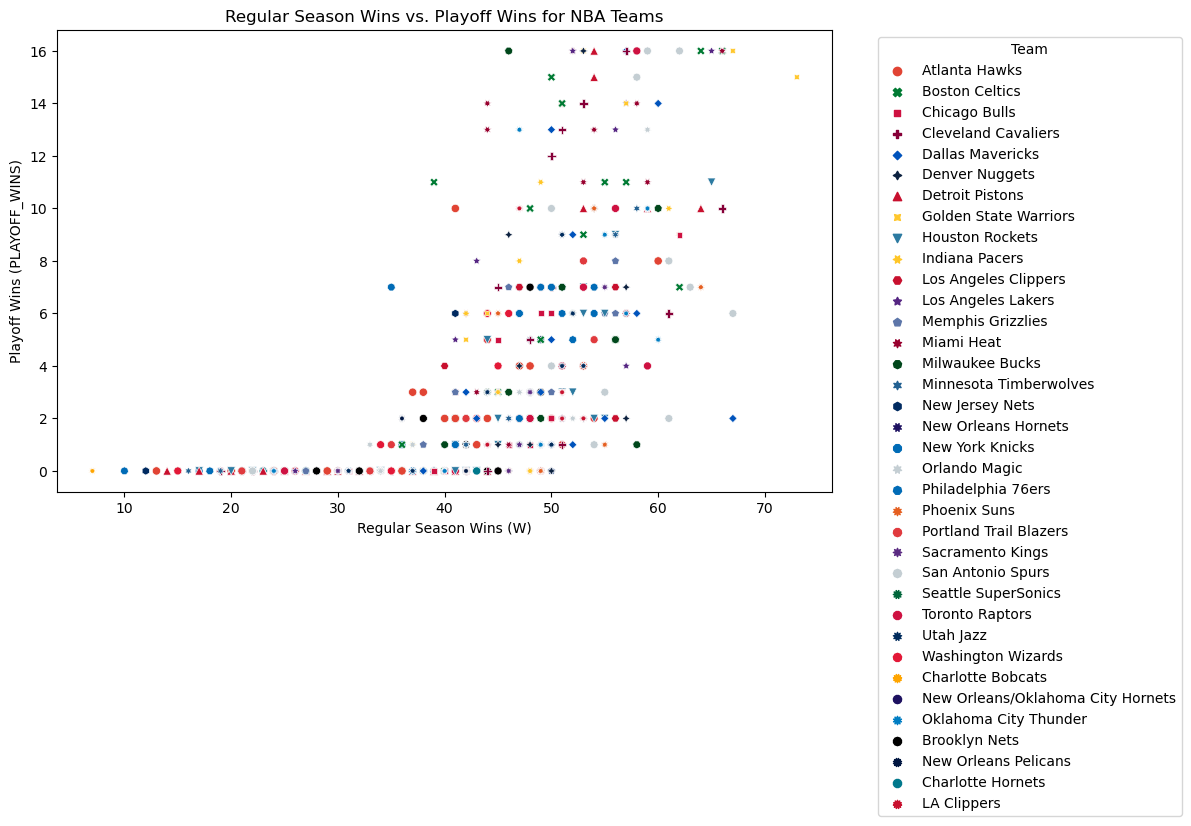

In [32]:
# Create a scatter plot of Win Percentage vs. Playoff Wins
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='W', y='PLAYOFF_WINS', hue='TEAM_NAME',style = 'TEAM_NAME', palette=palette,)
plt.title('Regular Season Wins vs. Playoff Wins for NBA Teams')
plt.xlabel('Regular Season Wins (W)')
plt.ylabel('Playoff Wins (PLAYOFF_WINS)')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

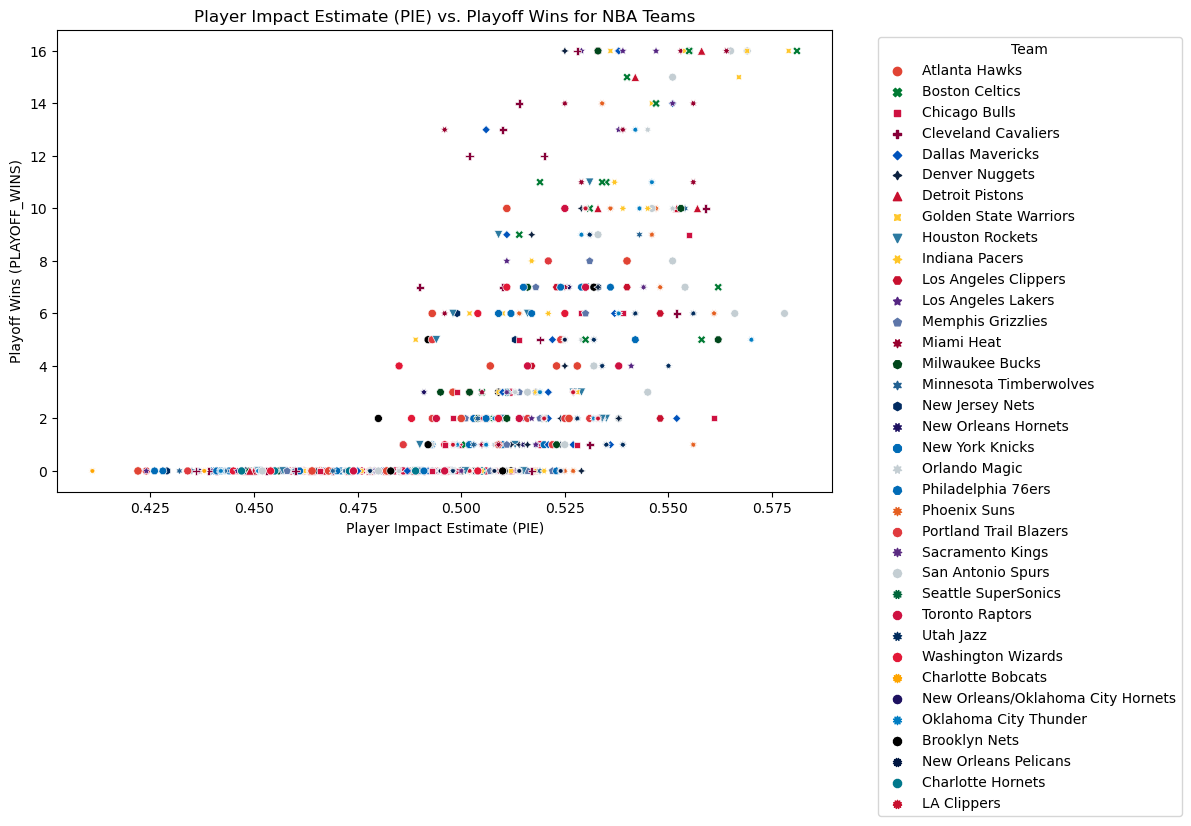

In [34]:
# Create a scatter plot of PIE (Player Impact Estimate) vs. Playoff Wins
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='PIE', y='PLAYOFF_WINS', hue='TEAM_NAME',style = 'TEAM_NAME', palette=palette)
plt.title('Player Impact Estimate (PIE) vs. Playoff Wins for NBA Teams')
plt.xlabel('Player Impact Estimate (PIE)')
plt.ylabel('Playoff Wins (PLAYOFF_WINS)')
plt.legend(title='Team',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

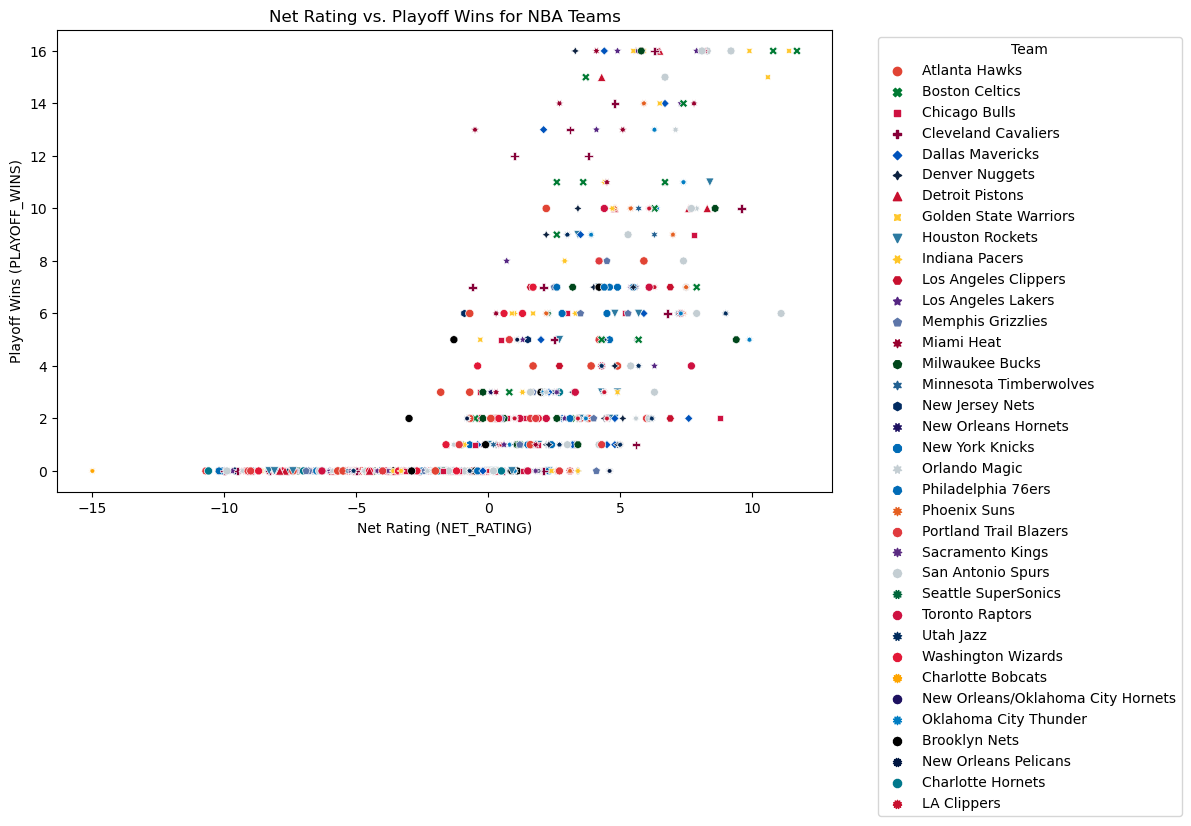

In [35]:
# Create a scatter plot of Net Rating vs. Playoff Wins
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='NET_RATING', y='PLAYOFF_WINS', hue='TEAM_NAME',style ='TEAM_NAME', palette=palette)
plt.title('Net Rating vs. Playoff Wins for NBA Teams')
plt.xlabel('Net Rating (NET_RATING)')
plt.ylabel('Playoff Wins (PLAYOFF_WINS)')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

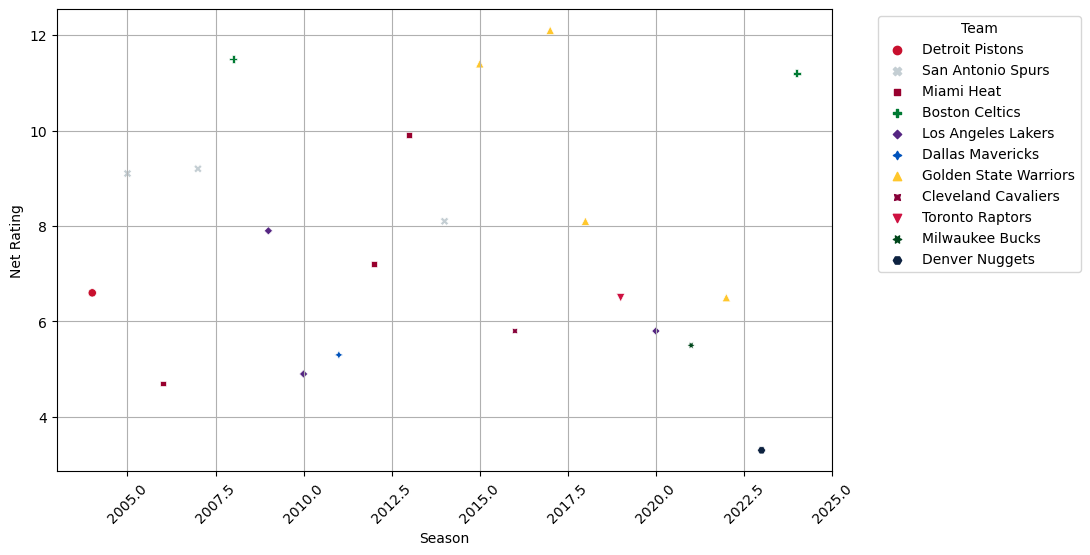

In [38]:
finalists = merged_df.query('PLAYOFF_WINS > 15')
plt.figure(figsize=(10, 6))
sns.scatterplot(data = finalists, x = 'SEASON', y = 'E_NET_RATING',hue = 'TEAM_NAME',style ='TEAM_NAME',palette=palette)
plt.xlabel('Season')
plt.ylabel('Net Rating')
plt.xticks(rotation=45)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

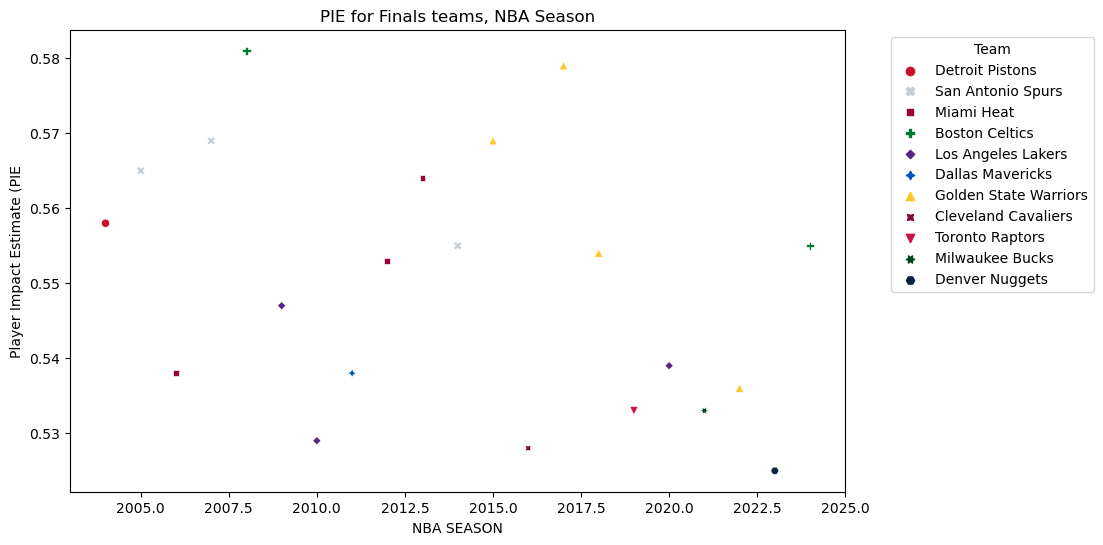

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=finalists, x='SEASON', y='PIE', hue='TEAM_NAME',style ='TEAM_NAME', palette=palette)
plt.title('PIE for Finals teams, NBA Season')
plt.xlabel('NBA SEASON')
plt.ylabel('Player Impact Estimate (PIE')
plt.legend(title='Team',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Building the ML Models

My training set will be built off of advanced data starting from the 2004-05 NBA season since that was the first year the NBA had 30 teams.

In [552]:
X=merged_df.loc[merged_df['SEASON']>2004]
y=X[target].astype(int).to_numpy()
X= X[features]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=47)

In [554]:
X.shape

(600, 23)

Since my training data has over 10,000 data points, I have decided to go with an XGBoost Regressor for my data. Although number of wins is a discrete variable, The categories(1 win, 2 wins, etc.) will not have enough data for my model to learn from without resampling.

## XGBoost Regressor

First, I will hypertune the parameters for my random forest regressor

In [557]:
mod = XGBRegressor()
learning_rate = [0.0001,0.001,0.01,0.1,0.2,0.3]
n_estimators = np.arange(10,201,10)
max_depth = np.arange(5,51,5)
param_grid = dict(learning_rate=learning_rate,n_estimators = n_estimators.tolist(),
                 max_depth = max_depth.tolist())

In [563]:
grid_search = GridSearchCV(mod,param_grid, scoring = 'r2',n_jobs = -1)

In [567]:
grid_results = grid_search.fit(X,y)

In [569]:
max(grid_search.cv_results_['mean_test_score'])

0.5715237231825663

In [ ]:
grid_search.cv_results_['params']

In [571]:
grid_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

The best Model seems to be a XGBoost Regressor with n_estimators = 10, max_depth = 10,and a learning rate = 0.3

In [574]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=10, learning_rate=0.3, max_depth=10)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print("XGBoost R2 Score:", xgb.score(X_test,y_test))


XGBoost R2 Score: 0.6493470393195232


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

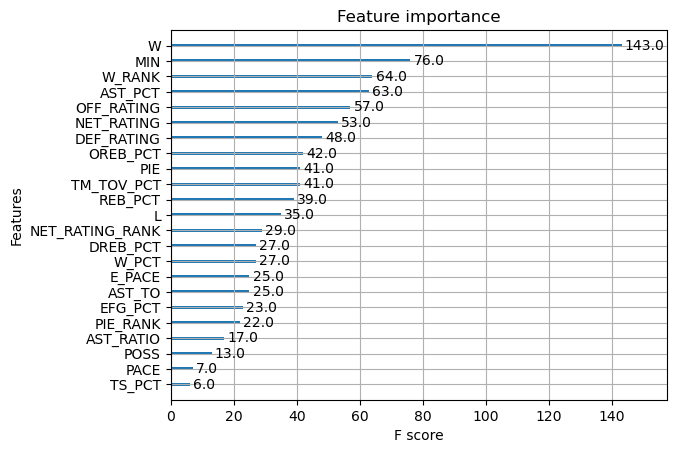

In [576]:
xgboost.plot_importance(xgb)

My current model predicts 65% of the variance based on my selected features. The Most important feature is obvious which is the number of wins a team has. Minutes was also important and assist percentage was the 3rd most important. Unsurprisingly, Pace is one of the least important stats that translates to postseason success. This is because young and developing teams with little to no identity are typically high pace teams.

In [588]:
test_X= merged_df.loc[merged_df['SEASON']==2023]
test_y=test_X[target]
test_X=test_X[features]
y_2023 = xgb.predict(test_X)
print(xgb.score(test_X,test_y))

0.9501538947013481


## Practice with Real World Data!

In [590]:
idx_2023 = test_X.index
df_2023 = merged_df.iloc[idx_2023] 
df_2023['PREDICTED_PLAYOFF_WINS']=np.round(y_2023)
df_2023.set_index('TEAM_NAME', inplace=True)
df_2023[['SEASON','W','L','W_PCT','PLAYOFF_WINS','PREDICTED_PLAYOFF_WINS']]

/var/folders/b1/30v46zsn0lqf896hxw53sls40000gn/T/ipykernel_6385/798209871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['PREDICTED_PLAYOFF_WINS']=np.round(y_2023)


,SEASON,W,L,W_PCT,PLAYOFF_WINS,PREDICTED_PLAYOFF_WINS
TEAM_NAME,,,,,,
Atlanta Hawks,2023,41,41,0.500,2.0,2.0
Boston Celtics,2023,57,25,0.695,11.0,11.0
Brooklyn Nets,2023,45,37,0.549,0.0,0.0
Charlotte Hornets,2023,27,55,0.329,0.0,0.0
Chicago Bulls,2023,40,42,0.488,0.0,0.0
Cleveland Cavaliers,2023,51,31,0.622,1.0,1.0
Dallas Mavericks,2023,38,44,0.463,0.0,0.0
Denver Nuggets,2023,53,29,0.646,16.0,15.0
Detroit Pistons,2023,17,65,0.207,0.0,0.0


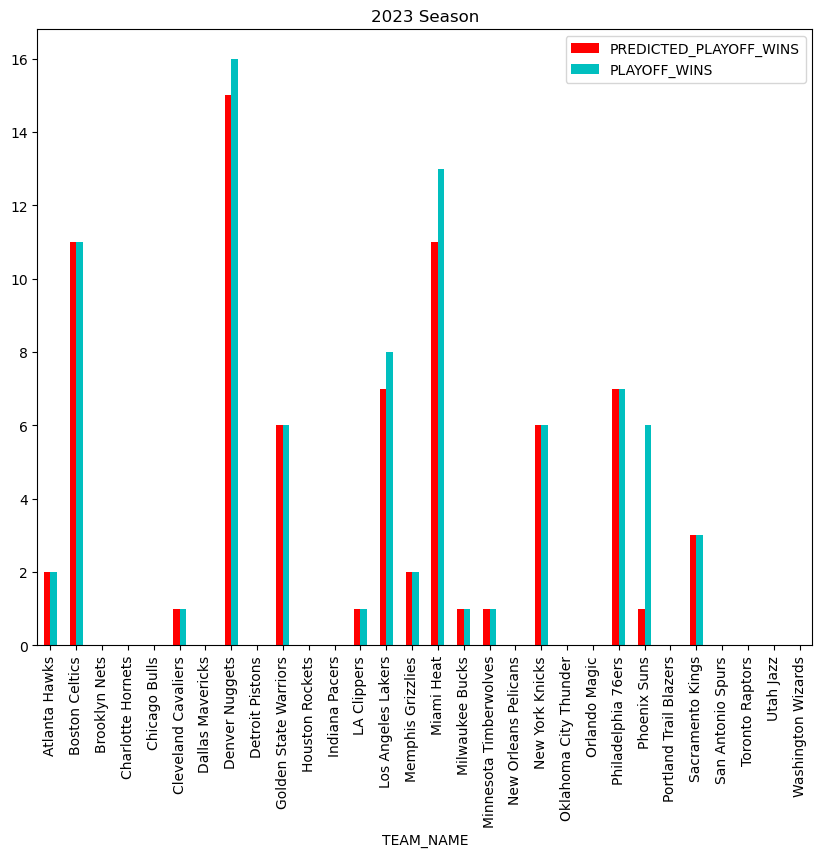

In [592]:
fig,ax = plt.subplots(figsize=(10,8))
df_2023[['PREDICTED_PLAYOFF_WINS','PLAYOFF_WINS']].plot(kind='bar',ax=ax,title='2023 Season',color=['r','c'])
plt.show()

In [594]:
#Predicting number of wins for the 2024 season
test_X= merged_df.loc[merged_df['SEASON']==2024]
test_y=test_X[target]
test_X=test_X[features]
y_2024 = xgb.predict(test_X)
print(xgb.score(test_X,test_y))

0.8203336400588033


In [596]:
idx_2024 = test_X.index
df_2024 = merged_df.iloc[idx_2024]
df_2024['PREDICTED_PLAYOFF_WINS']=np.round(y_2024)
df_2024.set_index('TEAM_NAME', inplace=True)
df_2024[['SEASON','W','L','W_PCT','PLAYOFF_WINS','PREDICTED_PLAYOFF_WINS']]

/var/folders/b1/30v46zsn0lqf896hxw53sls40000gn/T/ipykernel_6385/916497697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['PREDICTED_PLAYOFF_WINS']=np.round(y_2024)


,SEASON,W,L,W_PCT,PLAYOFF_WINS,PREDICTED_PLAYOFF_WINS
TEAM_NAME,,,,,,
Atlanta Hawks,2024,36,46,0.439,0.0,0.0
Boston Celtics,2024,64,18,0.780,16.0,15.0
Brooklyn Nets,2024,32,50,0.390,0.0,0.0
Charlotte Hornets,2024,21,61,0.256,0.0,0.0
Chicago Bulls,2024,39,43,0.476,0.0,0.0
Cleveland Cavaliers,2024,48,34,0.585,5.0,5.0
Dallas Mavericks,2024,50,32,0.610,13.0,5.0
Denver Nuggets,2024,57,25,0.695,7.0,7.0
Detroit Pistons,2024,14,68,0.171,0.0,0.0


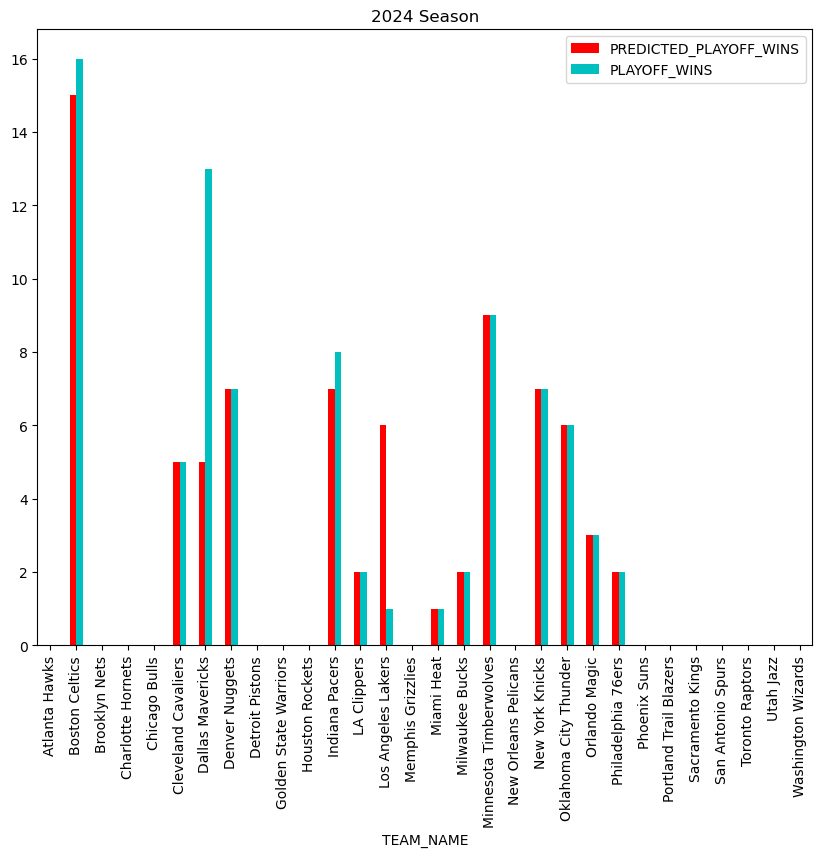

In [602]:
fig,ax = plt.subplots(figsize=(10,8))
df_2024[['PREDICTED_PLAYOFF_WINS','PLAYOFF_WINS']].plot(kind='bar',ax=ax,title='2024 Season',color=['r','c'])
plt.show()

In [600]:
dx_2024 = test_X.index
df_2024 = merged_df.iloc[idx_2024]
df_2024['PREDICTED_PLAYOFF_WINS']=np.round(y_2024)
df_2024.set_index('TEAM_NAME', inplace=True)
df_2024[['SEASON','W','L','W_PCT','PLAYOFF_WINS','PREDICTED_PLAYOFF_WINS']]

/var/folders/b1/30v46zsn0lqf896hxw53sls40000gn/T/ipykernel_6385/787366024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['PREDICTED_PLAYOFF_WINS']=np.round(y_2024)


,SEASON,W,L,W_PCT,PLAYOFF_WINS,PREDICTED_PLAYOFF_WINS
TEAM_NAME,,,,,,
Atlanta Hawks,2024,36,46,0.439,0.0,0.0
Boston Celtics,2024,64,18,0.780,16.0,15.0
Brooklyn Nets,2024,32,50,0.390,0.0,0.0
Charlotte Hornets,2024,21,61,0.256,0.0,0.0
Chicago Bulls,2024,39,43,0.476,0.0,0.0
Cleveland Cavaliers,2024,48,34,0.585,5.0,5.0
Dallas Mavericks,2024,50,32,0.610,13.0,5.0
Denver Nuggets,2024,57,25,0.695,7.0,7.0
Detroit Pistons,2024,14,68,0.171,0.0,0.0


In [604]:
stats_2025 = leaguedashteamstats.LeagueDashTeamStats(season='2024-25', per_mode_detailed='PerGame',**params)
X_2025_tot = stats_2025.get_data_frames()[0]
X_2025 = X_2025_tot[features]
y_2025 = xgb.predict(X_2025)


In [606]:
idx_2025 = X_2025.index
df_2025 = X_2025_tot.iloc[idx_2025]
df_2025['PREDICTED_PLAYOFF_WINS']=np.round(y_2025)
df_2025.set_index('TEAM_NAME', inplace=True)
df_2025[['W','L','W_PCT','PREDICTED_PLAYOFF_WINS']]

,W,L,W_PCT,PREDICTED_PLAYOFF_WINS
TEAM_NAME,,,,
Atlanta Hawks,36,40,0.474,1.0
Boston Celtics,56,20,0.737,10.0
Brooklyn Nets,25,52,0.325,0.0
Charlotte Hornets,19,57,0.250,0.0
Chicago Bulls,34,42,0.447,1.0
Cleveland Cavaliers,61,15,0.803,9.0
Dallas Mavericks,38,39,0.494,1.0
Denver Nuggets,47,30,0.610,12.0
Detroit Pistons,42,34,0.553,3.0


For the 2025 NBA playoffs, my model has the Denver Nuggets as the most likely team to win the NBA finals! The Oklahoma City Thunder are the second most likely team to win the finals! Only time will tell how accurate this result is!